In [1]:
!pip install diffrax

In [2]:
from functools import partial
from typing import Callable
import os

from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
import optax

from jaxtyping import Float, Array, PRNGKeyArray

key = jax.random.key(42)

### 1. Review the results of the ConservNet model applied to the 2D Kepler (Sun-Earth) configuration. If the results are not satisfactory, provide a detailed analysis and discussion. (60pts)

In [3]:
## DEMO KEPLER DATASET GENERATION CODE

import math
import numpy as np

class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Body:
    def __init__(self, location, mass, velocity, name=""):
        self.location = location
        self.mass = mass
        self.velocity = velocity
        self.name = name

def run_simulation(bodies, dt=1, steps=10000):
    G = 6.67408e-11

    # Initialize the history of body locations and velocities
    history = [{"name": body.name, "x": [], "y": [], "z": [], "vx": [], "vy": [], "vz": []} for body in bodies]

    for step in range(1, steps + 1):
        # Calculate accelerations
        accelerations = [Point(0, 0, 0) for _ in bodies]
        for i, target_body in enumerate(bodies):
            for j, external_body in enumerate(bodies):
                if i != j:
                    dx = external_body.location.x - target_body.location.x
                    dy = external_body.location.y - target_body.location.y
                    dz = external_body.location.z - target_body.location.z
                    r_squared = dx**2 + dy**2 + dz**2
                    r = math.sqrt(r_squared)
                    factor = G * external_body.mass / r_squared**1.5
                    accelerations[i].x += factor * dx
                    accelerations[i].y += factor * dy
                    accelerations[i].z += factor * dz

        # Update velocities and positions
        for i, body in enumerate(bodies):
            body.velocity.x += accelerations[i].x * dt
            body.velocity.y += accelerations[i].y * dt
            body.velocity.z += accelerations[i].z * dt
            if body.name != 'sun':
                body.location.x += body.velocity.x * dt
                body.location.y += body.velocity.y * dt
                body.location.z += body.velocity.z * dt

        # Record data
        if step % int(1/dt) == 0:
            for i, body in enumerate(bodies):
                hist = history[i]
                hist["x"].append(body.location.x)
                hist["y"].append(body.location.y)
                hist["z"].append(body.location.z)
                hist["vx"].append(body.velocity.x)
                hist["vy"].append(body.velocity.y)
                hist["vz"].append(body.velocity.z)

    return history

def system_P2(batch_size):
    counter = 0
    G = 6.67408e-11
    while True:
        loc1 = np.random.uniform(-5, 5)
        loc2 = np.random.uniform(-5, 5)
        vel1 = np.random.uniform(-5, 5)
        vel2 = np.random.uniform(-5, 5)

        sun = Body(Point(0, 0, 0), 1/G, Point(0, 0, 0), "sun")
        earth = Body(Point(loc1, loc2, 0), 1, Point(vel1, vel2, 0), "earth")

        bodies = [sun, earth]
        burn_steps = 3
        dt = 0.01
        results = run_simulation(bodies, dt=dt, steps=int((1/dt)*(batch_size+burn_steps)+1))

        # Save earth's position & velocity information
        x = np.array(results[1]['x'][burn_steps:])
        y = np.array(results[1]['y'][burn_steps:])
        vx = np.array(results[1]['vx'][burn_steps:])
        vy = np.array(results[1]['vy'][burn_steps:])

        angular_momentum = x * vy - y * vx
        energy = 0.5 * (vx**2 + vy**2) - 1 / np.sqrt(x**2 + y**2)
        mean_angular_momentum = np.mean(angular_momentum)
        mean_energy = np.mean(energy)

        if np.std(angular_momentum) < 1e-3 and np.std(energy) < 1e-3:
            eccentricity = np.sqrt(1 + 2 * (mean_angular_momentum**2) * mean_energy)
            if eccentricity < 0.99:
                break

    state_vectors = np.array([x, y, vx, vy]).T
    labels = np.array([np.array([mean_angular_momentum, mean_energy]) for _ in range(batch_size)])
    return state_vectors, labels

Equation of motion:
\begin{equation}
    \frac{d\mathbf v}{dt}=-\frac{\alpha}{r^3}\mathbf r,\quad \frac{d\mathbf x}{dt} = \mathbf v
\end{equation}

Conserved Quantities:
- Energy
\begin{equation}
    E=\frac{1}{2}(v_x^2 + v_y^2) - \frac{\alpha}{r}
\end{equation}
- Angular momentum
\begin{equation}
    L_z=xv_y - yv_x
\end{equation}
- Laplace-Runge-Lenz vector
\begin{equation}
    A_x=L_zv_y-\alpha\frac{x}{r}, \quad A_y=-L_zv_x-\alpha\frac{y}{r}
\end{equation}
Where $r=\sqrt{x^2 + y^2}$

$(E, L_z, A_x\,\text{or}\, A_y)$ froms the independent invariant quantity. Another invariant quantities are the combination of these three quantities, $F(E, L_z, A_x)$.

In [4]:
# YOUR CODE HERE (5pts)

def force(x, alpha):
    return - ((alpha) / (jnp.linalg.norm(x) ** 3)) * x

# YOUR DATASET GENERATION CODE HERE
@partial(jax.jit, static_argnames=("dt", "n_steps", "solver"))
def run_simulation(
    x0: Float[Array, "2"],
    v0: Float[Array, "2"],
    alpha: Float[Array, ""],
    dt: float,
    n_steps: int,
    solver: diffrax.AbstractERK
):
    def f(t, y, args):
        x, v = y
        alpha = args
        dxdt = v
        dvdt = force(x, alpha)
        return (dxdt, dvdt)

    terms = diffrax.ODETerm(f)
    y0 = (x0, v0)
    saveat = diffrax.SaveAt(steps=True)
    args = alpha

    sols = diffrax.diffeqsolve(
        terms, solver, 0, dt * n_steps, dt, y0, args, saveat=saveat, max_steps=n_steps
    )

    xs, vs = sols.ys
    return xs, vs


def generate_dataset(
    n_trajectories,
    n_batchs,
    n_steps,
    xmin = -5,
    xmax = 5,
    vmin = -5,
    vmax = 5,
    alpha = 100.0,
    tol = 1e-3,
    dt = 0.01,
    solver = diffrax.Dopri8(),
    *,
    key
):
    n_samples = 0
    trajectories = jnp.empty((n_trajectories, n_steps, 4))
    consv_quants = jnp.empty((n_trajectories, n_steps, 4))

    pbar = tqdm(total=n_trajectories, desc="Generating trajectories")

    while n_samples < n_trajectories:
        key, key1, key2 = jax.random.split(key, 3)
        x0 = jax.random.uniform(key1, (n_batchs, 2), minval=xmin, maxval=xmax)
        v0 = jax.random.uniform(key2, (n_batchs, 2), minval=vmin, maxval=vmax)

        xs, vs = jax.vmap(run_simulation, in_axes=(0, 0, None, None, None, None), out_axes=(0, 0))(x0, v0, alpha, dt, n_steps, solver)

        rs = jnp.linalg.norm(xs, axis=-1)
        energy = 0.5 * jnp.sum(vs ** 2, axis=-1) - (alpha / rs)
        angular_momentum = xs[..., 0] * vs[..., 1] - xs[..., 1] * vs[..., 0]
        lrl_x = angular_momentum * vs[..., 1] - alpha * xs[..., 0] / rs
        lrl_y = -angular_momentum * vs[..., 0] - alpha * xs[..., 1] / rs

        states = jnp.concatenate([xs, vs], axis=-1)
        labels = jnp.stack([energy, angular_momentum, lrl_x, lrl_y], axis=-1)

        valid = (jnp.std(energy, axis=1) < tol) & (jnp.std(angular_momentum, axis=1) < tol)
        valid = np.array(valid)
        n_valid = valid.sum()


        to_take = min(n_valid, n_trajectories - n_samples)
        if to_take > 0:
            idxs = np.where(valid)[0][:to_take]
            trajectories = trajectories.at[n_samples:n_samples+to_take].set(states[idxs])
            consv_quants = consv_quants.at[n_samples:n_samples+to_take].set(labels[idxs])
            n_samples += to_take
            pbar.update(to_take)

    return trajectories, consv_quants

In [5]:
n_trajectories = 4096
n_sim_batches = 64 # for simulation
n_steps = 2048

datasetkey, key = jax.random.split(key)

alpha = 100.0

trajectories, consv_quants = generate_dataset(
    n_trajectories,
    n_sim_batches,
    n_steps,
    key=datasetkey
)

Generating trajectories:   0%|          | 0/4096 [00:00<?, ?it/s]

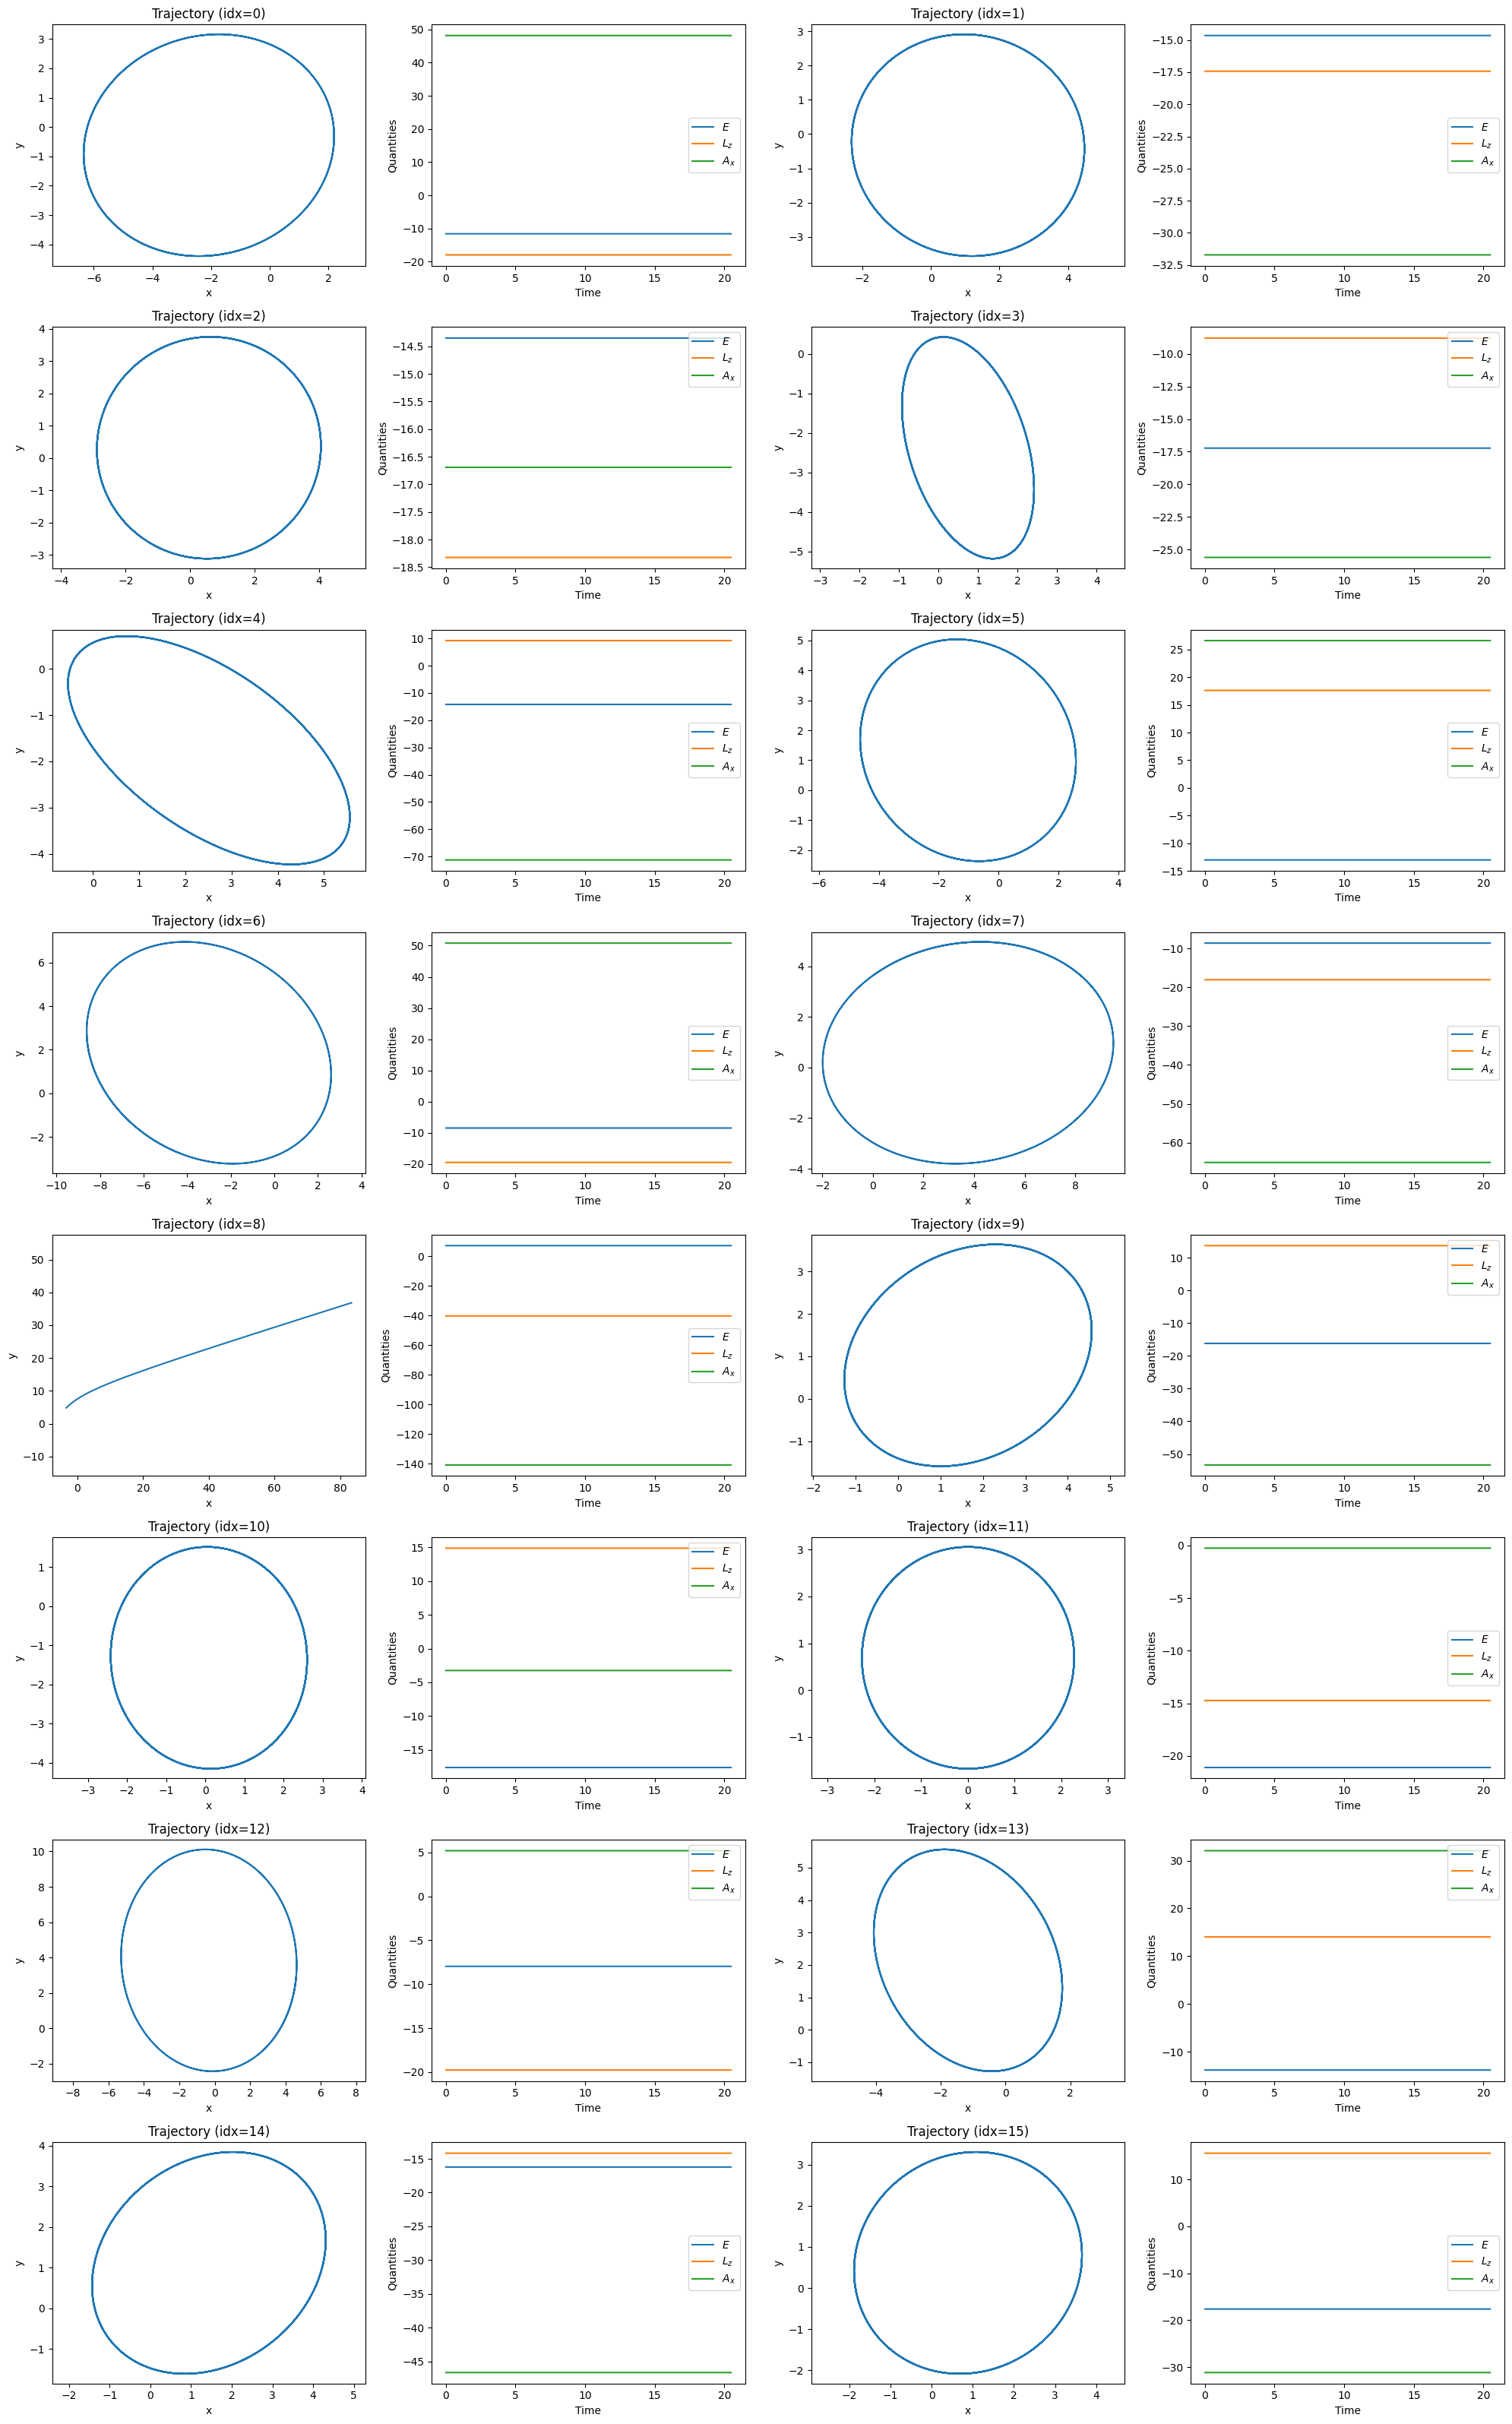

In [6]:
dt = 0.01
ts = jnp.arange(0, n_steps * dt, dt) + dt

n_indices = 16
n_per_row = 2
n_rows = n_indices // n_per_row
n_cols = 4  # [traj, cons] x 2

# subplot 생성
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))

for i in range(n_rows):
    idx0 = 2 * i
    idx1 = idx0 + 1

    for j, idx in enumerate([idx0, idx1]):
        col_traj = j * 2
        col_cons = j * 2 + 1

        # ── trajectory ──
        ax_traj = axes[i, col_traj]
        xs = trajectories[idx, :, :2]
        ax_traj.plot(xs[:, 0], xs[:, 1])
        ax_traj.set_title(f"Trajectory (idx={idx})")
        ax_traj.set_xlabel("x")
        ax_traj.set_ylabel("y")
        ax_traj.axis("equal")

        # ── conserved quantities ──
        ax2 = axes[i, col_cons]
        energy = consv_quants[idx, :, 0]
        angmom = consv_quants[idx, :, 1]
        lrl_x = consv_quants[idx, :, 2]

        ax2.plot(ts, energy, label='$E$', color='tab:blue')
        ax2.plot(ts, angmom, label='$L_z$', color='tab:orange')
        ax2.plot(ts, lrl_x, label='$A_x$', color='tab:green')


        ax2.set_xlabel("Time")
        ax2.set_ylabel("Quantities")

        ax2.legend()

plt.tight_layout()
plt.show()

Mean E: -14.6903, std E: 8.7953
Mean L: -0.5974, std L: 16.0027
Mean A_x: -0.7105, std A_x: 49.5117
Mean A_y: 1.1219, std A_y: 48.6415
Mean arg_A: 0.0044, std arg_A: 1.7834


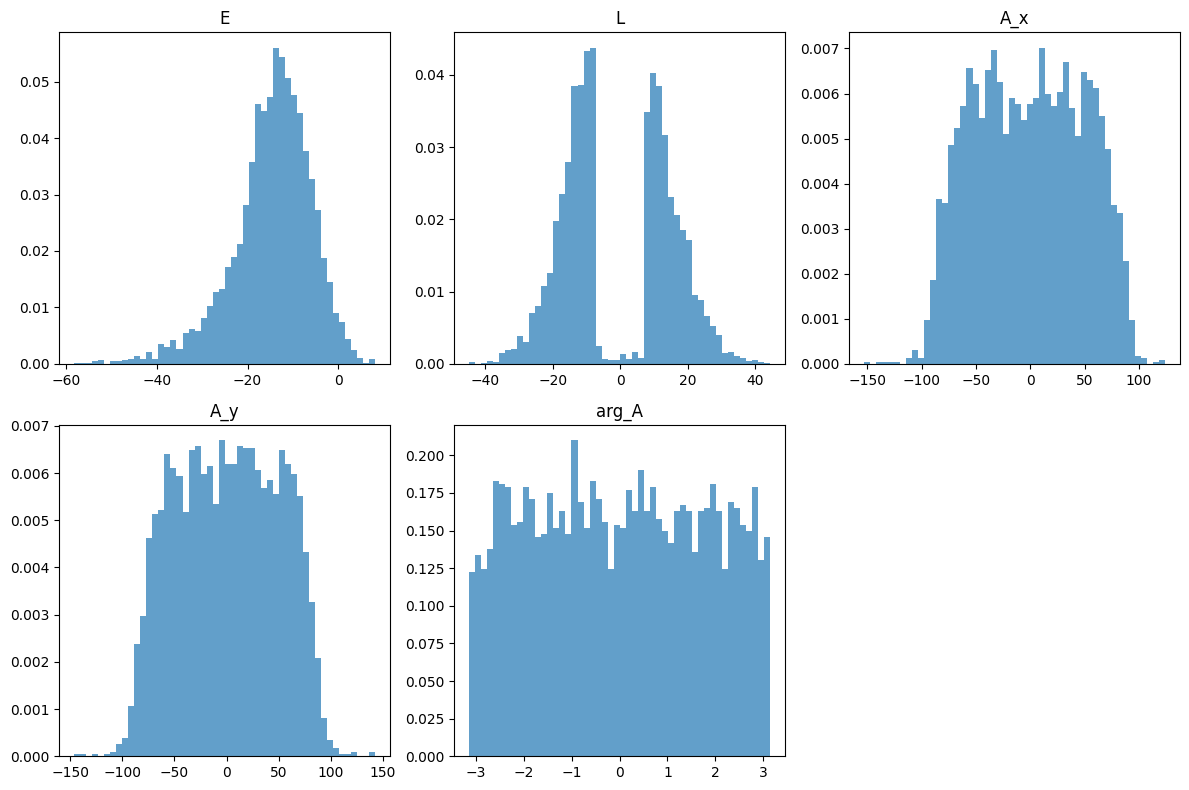

In [7]:
E = consv_quants[..., 0]
L = consv_quants[..., 1]
A_x = consv_quants[..., 2]
A_y = consv_quants[..., 3]
arg_A = jnp.arctan2(A_x, A_y)
mean_E = jnp.mean(E)
std_E = jnp.std(jnp.mean(E, axis=-1))
mean_L = jnp.mean(L)
std_L = jnp.std(jnp.mean(L, axis=-1))
print(f"Mean E: {jnp.mean(E):.4f}, std E: {jnp.std(E):.4f}")
print(f"Mean L: {jnp.mean(L):.4f}, std L: {jnp.std(L):.4f}")
print(f"Mean A_x: {jnp.mean(A_x):.4f}, std A_x: {jnp.std(A_x):.4f}")
print(f"Mean A_y: {jnp.mean(A_y):.4f}, std A_y: {jnp.std(A_y):.4f}")
print(f"Mean arg_A: {jnp.mean(arg_A):.4f}, std arg_A: {jnp.std(arg_A):.4f}")

datasets = [E, L, A_x, A_y, arg_A]
datasets = [jnp.mean(d, axis=-1) for d in datasets]
labels   = ['E', 'L', 'A_x', 'A_y', 'arg_A']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (data, label) in enumerate(zip(datasets, labels)):
    axes[idx].hist(np.array(data), bins=50, density=True, alpha=0.7)
    axes[idx].set_title(label)

axes[5].axis('off')  # 마지막 칸 비우기
plt.tight_layout()
plt.show()

In [8]:
# YOUR CODE HERE (15pts)

# RE-DESIGN OR USE CONSERVNET
# YOUR NEURAL NETWORK CODE HERE

class ConservNet(eqx.Module):
    net: eqx.nn.Sequential

    def __init__(
        self,
        hidden_size: int=160,
        activation: Callable=jax.nn.mish,
        *,
        key: PRNGKeyArray
    ):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        self.net = eqx.nn.Sequential([
            eqx.nn.Linear(4, hidden_size, key=key1),
            eqx.nn.Lambda(activation),
            eqx.nn.Linear(hidden_size, hidden_size, key=key2),
            eqx.nn.Lambda(activation),
            eqx.nn.Linear(hidden_size, hidden_size, key=key3),
            eqx.nn.Lambda(activation),
            eqx.nn.Linear(hidden_size, hidden_size, key=key4),
            eqx.nn.Lambda(activation),
            eqx.nn.Linear(hidden_size, 3, key=key5)
        ])

    def __call__(self, x):
        return self.net(x)

def xavier_normal(weight: jax.Array, key: jax.random.PRNGKey) -> jax.Array:
    out, inp = weight.shape
    gain = jnp.sqrt(2.0)
    std = gain * jnp.sqrt(2.0 / (inp + out))
    return std * jax.random.normal(key, (out, inp))

def apply_xavier_init(model: eqx.Module, key: jax.random.PRNGKey) -> eqx.Module:
    leaves, treedef = jax.tree_util.tree_flatten(model)
    num_weights = sum(isinstance(leaf, jnp.ndarray) and leaf.ndim == 2 for leaf in leaves)
    subkeys = jax.random.split(key, num_weights)
    idx = 0
    new_leaves = []
    for leaf in leaves:
        if isinstance(leaf, jnp.ndarray) and leaf.ndim == 2:
            new_leaves.append(xavier_normal(leaf, subkeys[idx]))
            idx += 1
        elif isinstance(leaf, jnp.ndarray) and leaf.ndim == 1:
            new_leaves.append(jnp.zeros_like(leaf))
        else:
            new_leaves.append(leaf)
    return jax.tree_util.tree_unflatten(treedef, new_leaves)

In [ ]:
# YOUR CODE HERE (15pts)

# RE-DESIGN OR USE CONSERVNET
# YOUR LOSS FUNCTION CODE HERE
@eqx.filter_value_and_grad
def compute_grad(
    model: eqx.Module,
    traj: Float[Array, "B T D"],
    noise: Float[Array, "B T D"],
    Q: float
):
    out = jax.vmap(jax.vmap(model))(traj) # (B, T, 4) -> (B, T, 3)
    var_orig = jnp.var(out, axis=1)

    out_perturbed = jax.vmap(jax.vmap(model))(traj + noise)
    var_perturbed = jnp.var(out_perturbed, axis=1)

    base_loss = jnp.mean(var_orig) + jnp.mean(jnp.clip(Q - var_perturbed, min=0))

    means = jnp.mean(out, axis=1)
    means_centered = means - jnp.mean(means, axis=0, keepdims=True)
    cov = jnp.einsum('bi,bj->ij', means_centered, means_centered) / means_centered.shape[0]
    off_diag = cov - jnp.diag(jnp.diagonal(cov))
    batch_mean_indep_penalty = jnp.sum(off_diag**2)
    return base_loss + 0.5 * batch_mean_indep_penalty


In [10]:
# YOUR CODE HERE (5pts)

# YOUR NEURAL NETWORK TRAINING CODE HERE
def data_loader(
    trajectories: Float[Array, "N T D"],
    batch_size: int,
    group_size: int,
    *,
    key,
    infinite=False
):
    n_traj, traj_len, _ = trajectories.shape
    slices = jnp.reshape(
        trajectories[:,:(traj_len // group_size) * group_size],
        (-1, group_size, 4)
    )
    dataset_size = slices.shape[0]
    indices = jnp.arange(dataset_size)

    while True:
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, indices)
        for start in range(0, dataset_size, batch_size):
            batch_idx = perm[start:start + batch_size]
            yield slices[batch_idx]

        if not infinite:
            break

def train(
    model: eqx.Module,
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
    data: Float[Array, "N T D"],
    batch_size: int,
    group_size: int,
    n_epochs: int,
    noise_std: float,
    Q: float,
    *,
    key: PRNGKeyArray
):
    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        opt_state: optax.OptState,
        traj_slices: Float[Array, "B T D"],
        key: PRNGKeyArray,
    ):
        key, new_key = jax.random.split(key)
        noise = jax.random.uniform(key, traj_slices.shape) * noise_std
        loss, grad = compute_grad(model, traj_slices, noise, Q)
        updates, new_opt_state = optim.update(
            grad, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )
        model = eqx.apply_updates(model, updates)
        grad_flat, _ = jax.flatten_util.ravel_pytree(grad)
        grad_norm = jnp.linalg.norm(grad_flat)
        return model, new_opt_state, new_key, loss, grad_norm

    n_traj, traj_len, _ = data.shape
    batches_per_epoch = n_traj * (traj_len // group_size) // batch_size

    loader_key, key = jax.random.split(key)
    train_loader = data_loader(data, batch_size, group_size, key=loader_key, infinite=True)
    step_iter = iter(train_loader)

    train_losses = np.zeros((n_epochs, batches_per_epoch))
    train_gradns = np.zeros((n_epochs, batches_per_epoch))
    pbar = tqdm(total=n_epochs * batches_per_epoch, desc=f"Epoch 0/{n_epochs}", unit="iterations")
    for epoch in range(n_epochs):
        pbar.set_description(f"Epoch {epoch+1}/{n_epochs}")
        for i in range(batches_per_epoch):
            slices = next(step_iter)
            model, opt_state, key, loss, grad_norm = make_step(
                model, opt_state, slices, key
            )
            train_losses[epoch, i] = float(loss)
            train_gradns[epoch, i] = float(grad_norm)
            pbar.update()
            pbar.set_postfix(loss=loss, gradnorm=grad_norm)

    return model, opt_state, train_losses.reshape((-1)), train_gradns.reshape((-1))

def save_model(model: eqx.Module, save_path: str):
    with open(save_path, "wb") as f:
        eqx.tree_serialise_leaves(f, model)

def load_model(load_path: str, **model_kwargs) -> eqx.Module:
    model_template = ConservNet(**model_kwargs, key=jax.random.key(0))  # dummy key for template
    with open(load_path, "rb") as f:
        model = eqx.tree_deserialise_leaves(f, model_template)
    return model

def plot_metrics(losses, gradnorms):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.set_yscale('log')
    ax1.plot(losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Grad Norm', color='tab:red')
    ax2.set_yscale('log')
    ax2.plot(gradnorms, color='tab:red', alpha=0.5, label='Grad Norm')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Training Metrics')
    plt.show()

Epoch 0/80:   0%|          | 0/20480 [00:00<?, ?iterations/s]

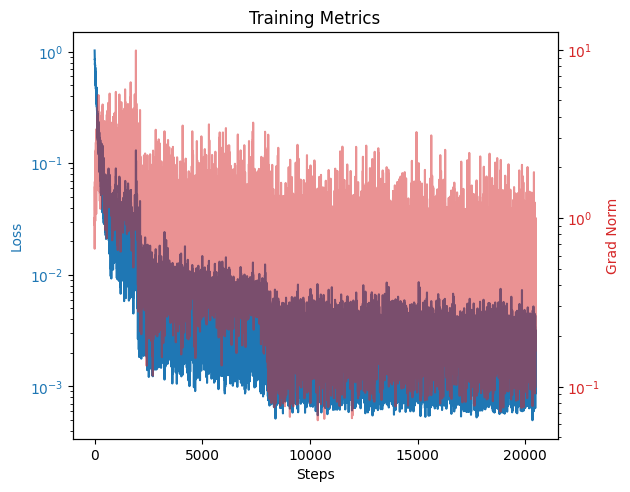

In [11]:

model_key, key = jax.random.split(key)
model = ConservNet(hidden_size=320, key=jax.random.key(0)) # dummy key
model = apply_xavier_init(model, key=model_key)


batch_size = 64
group_size = 512
n_epochs = 80
start_learning_rate = 3e-4
schedule = optax.piecewise_constant_schedule(
    init_value=start_learning_rate,
    boundaries_and_scales={2000: 0.1, 8000:0.1}
)
optim = optax.adamw(schedule)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trainer_key, key = jax.random.split(key)

# training
noise_std = 1.
Q = 1.
model, opt_state, train_losses, train_gradns = train(
    model, optim, opt_state, trajectories,
    batch_size, group_size, n_epochs,
    noise_std, Q,
    key=trainer_key
)

model_save_path = "conservnet_model.eqx"
save_model(model, model_save_path)

plot_metrics(train_losses, train_gradns)

In [12]:
# YOUR CODE HERE (5pts)

# YOUR VISUALIZATION CODE HERE
model_save_path = "./conservnet_model.eqx"
model = load_model(model_save_path, hidden_size=320)

In [13]:
consv_quants_pred = np.zeros((n_trajectories, 3))
for idx, traj in enumerate(tqdm(trajectories)):
    consv_quants_pred[idx, :] = np.mean(np.asarray(jax.vmap(model)(traj)), axis=0)
q1, q2, q3 = consv_quants_pred[..., 0], consv_quants_pred[..., 1], consv_quants_pred[..., 2]

  0%|          | 0/4096 [00:00<?, ?it/s]

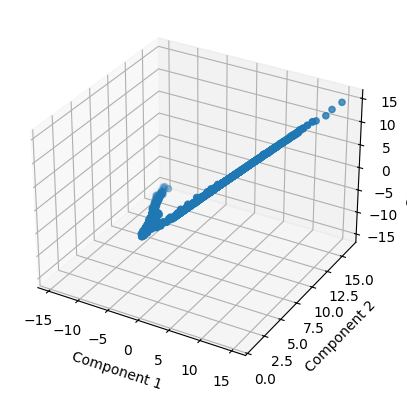

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q1, q2, q3)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()


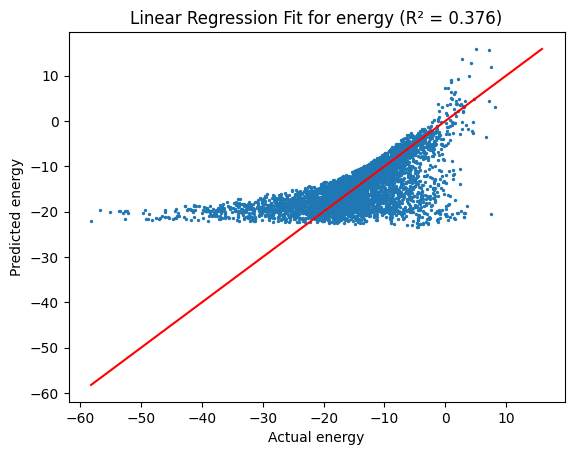

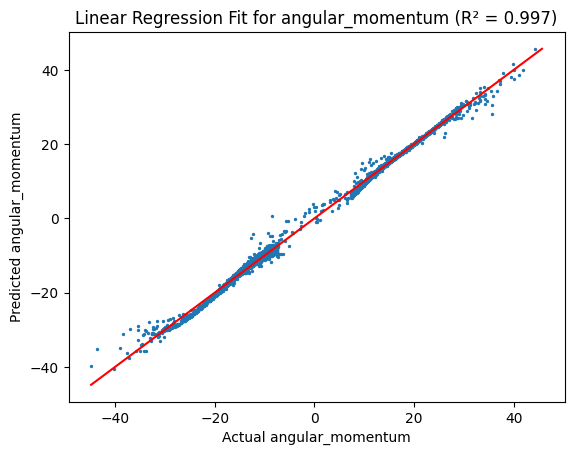

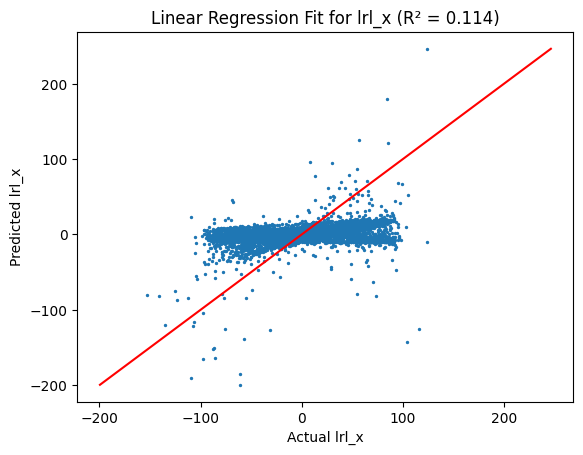

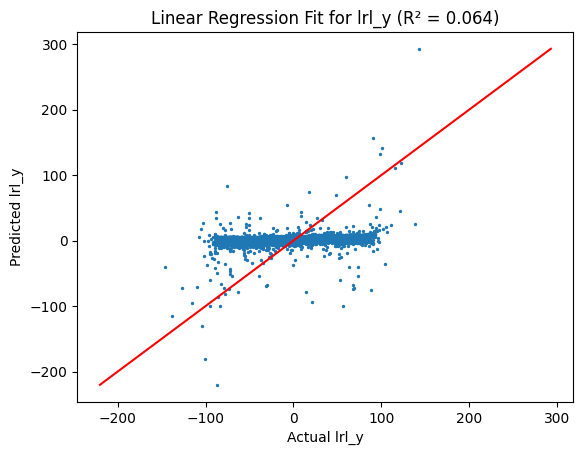

In [15]:
from sklearn.linear_model import LinearRegression

energies = jnp.mean(consv_quants[..., 0], axis=1)
angular_momentum = jnp.mean(consv_quants[..., 1], axis=1)
lrl_x = jnp.mean(consv_quants[..., 2], axis=1)
lrl_y = jnp.mean(consv_quants[..., 3], axis=1)

quantities = {
    "energy": energies,
    "angular_momentum": angular_momentum,
    "lrl_x": lrl_x,
    "lrl_y": lrl_y
}

features = consv_quants_pred
second = jnp.einsum("ni,nj->nij", features, features).reshape(features.shape[0], -1)
third = jnp.einsum("ni,nj,nk->nijk", features, features, features).reshape(features.shape[0], -1)
features = jnp.concatenate([features, second, third], axis=-1) # higher order polynomial feating

for name, q in quantities.items():
    model = LinearRegression()
    model.fit(features, q)
    q_pred = model.predict(features)

    r2 = model.score(features, q)

    # print(f"c1={model.coef_[0]:.3f}, c2={model.coef_[1]:.3f}, c3={model.coef_[2]:.3f}, b={model.intercept_:.3f}, R²={r2:.3f}")
    # 실제 vs 예측 플롯
    plt.figure()
    plt.scatter(q, q_pred, s=2)
    min_val = min(q.min(), q_pred.min())
    max_val = max(q.max(), q_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], c='red')  # 45도 레퍼런스 선
    plt.xlabel(f"Actual {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"Linear Regression Fit for {name} (R² = {r2:.3f})")
    plt.show()

### Discuss the results (15pts)

DISCUSSING THE ANALYSIS RESULTS (in 500 words, include graphics or tables by using markdown is fine)

- 분석할 System

\begin{equation}
    H(x, y, p_x, p_y) =\frac{p_x^2 + p_y^2}{2} - \frac{\alpha}{\sqrt{x^2 + y^2}}
\end{equation}
2D kepler problem은 phasespace dimension 4와, 독립인 보존량 3개($E$, $L$, $A_x$ or $A_y$)를 가지는 superintegrable system이다. 경로 하나에 대응되는 3 가지의 독립인 보존량이 존재하므로, conservnet의 출력을 3개로 두었다. conserv net이 보존량을 찾아낸다면 세 가지 보존량의 조합, $Q_(E, L, A_x)$일 것 이다.

- 모델 및 데이터셋

입력이 4차원(x, y, p_x, p_y)이고 출력이 3차원인 MLP를 사용했다. 320의 hidden size를 사용했으며, activation으로 mish와 sine를 사용했다.
8th-order Explicit Runge-Kutta를 이용해 생성한 2048 step의 trajectory를 4096개 생성해 학습에 사용했다. 2048step을 512step의 group 4개로 분할하고 섞여 총 16384개의 데이터를 사용했다. 


- 학습결과

Adam optimizer를 사용해 80 Epoch만큼 학습시켰다. 2000 step이후 Learning rate를 1/10로 줄였고, cosine annealing도 사용해보았으나, 큰 차이 없었다.
학습된 결과로 부터 polynomial regression하여 각 보존량을 잘 찾았는지 확인했다.

학습에 사용한 각 trajectory로부터 찾은 invariant quantity 3개를 3차원 scatter plot으로 플롯하였다. 3개의 invariant quantity가 서로 독립이기를 기대했으나, 대부분 일직선상에 분포하였다.

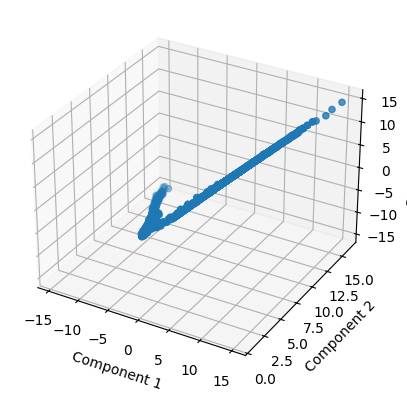



1. activation으로 mish를 사용하였을 때, 각운동량은 잘 찾았고, 총 역학적 에너지의 경우 약한 상관관계를 보였다. Laplace-Runge-Lenz vector는 찾지 못했다.
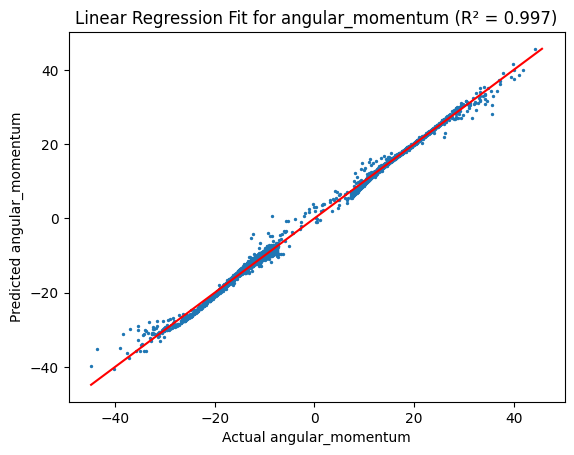
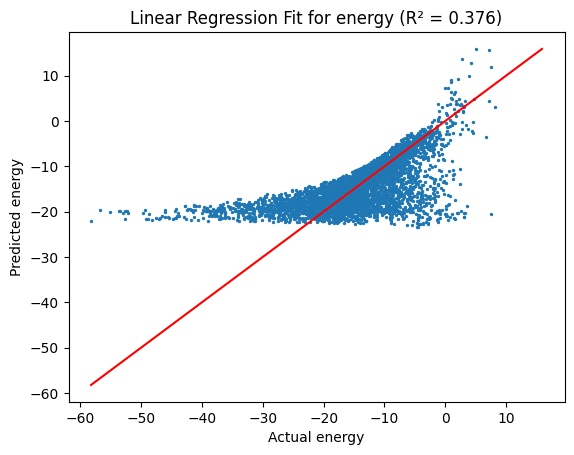

2. activation으로 sin을 사용 한 경우, 각운동량과 에너지는 잘 찾지 못했지만, Laplace-Runge-Lenz vector는 잘 찾아내었다.
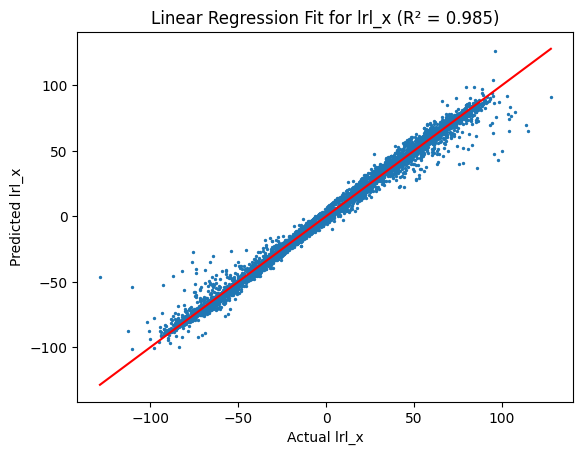
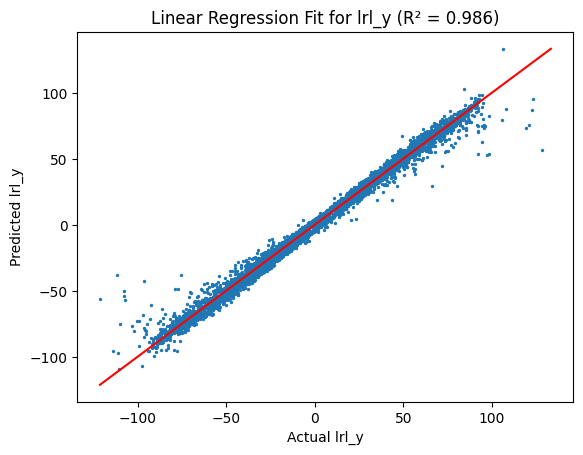


mish와 sine을 섞은 모델도 사용해보았으나, 동시에 여러가지 불변량을 식별해내는것은 불가능 했다.

서로 독립인 3개의 불변량을 찾아내는게 이상적이었으나, 모델 형태와 Activation에 따라 더 수렴하기 쉬운 불변량쪽으로 먼저 수렴 해버리는 것 같다. 2D Kepler system의 경우 어떤 형태의 보존량이 있는지 이미 정확히 알고 있기 때문에, 셋 중 하나를 제외한 2개를 고정시키고 데이터를 생성해 해당 불변량으로 수렴하는지 확인할 수 있으나, 어떤한 불변량이 몇 개 있는지 모르는 system의 경우, 불가능한 방법이다. 

- 개선방안 & 결과
3가지 invariant quantity를 한꺼번에 추정하지 못하는 문제를 해결하고자 하였다.
batch안에서 추정된 invariant quantity의 covariance의 off-diagonal term을 loss에 추가하였고, 한 update에 더 많은 batch를 계산하도록 하였다. 그 결과, 모델이 추정한 각 quantity가 서로 독립이 되도록 강제되면서, 다양한 invariant quantity를 한꺼번에 식별할 수 있었다. 대신 개별 invariant quantity에 대한 성능은 줄어들었다.

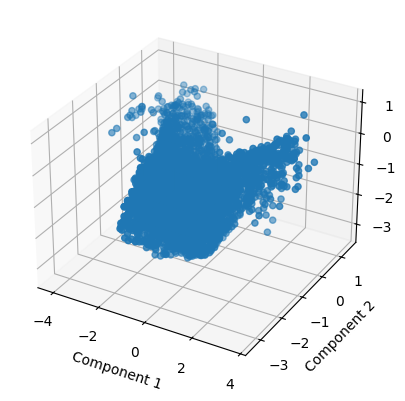


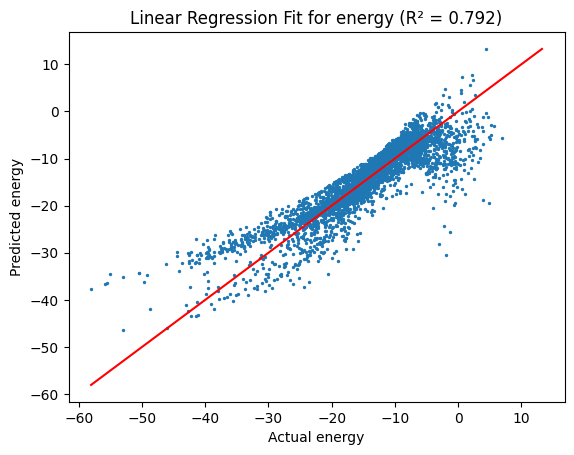
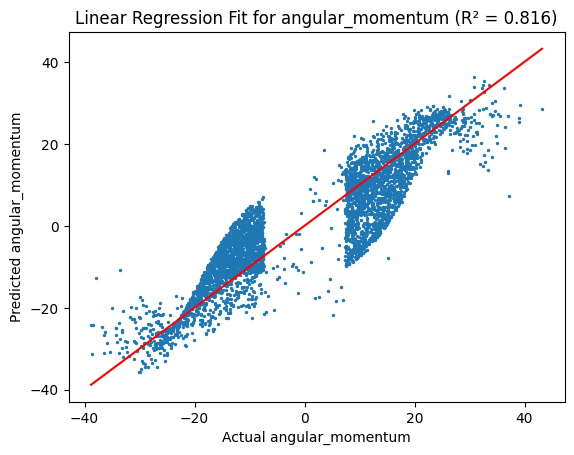
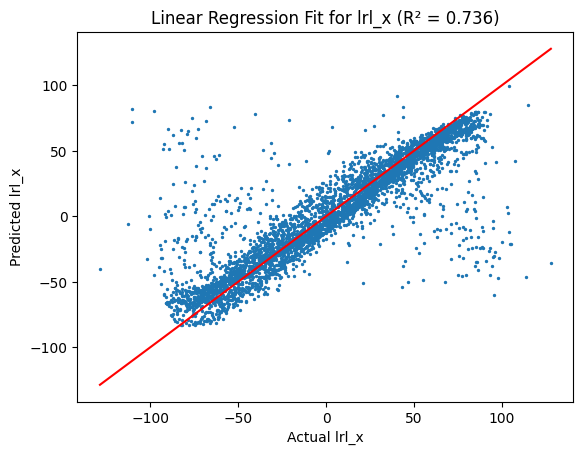
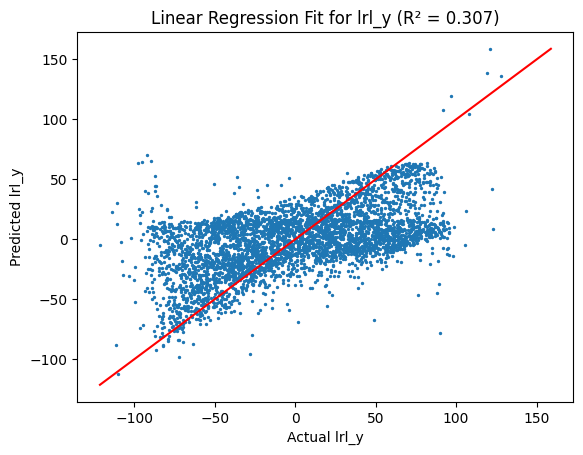

각운동량에서 0 근처가 비어있는것은 실제 분포를 따른 것이다. 데이터 생성시, 각운동량이 너무 작으면 행성 중심 stiff한 영역으로 끌려가, 오차가 크게 발생하고, rejection되어 비어있는 것으로 추정된다.

### 2. Explore potential methods or strategies to further enhance the performance of PINNs. (review articles, or just consideration is fine) (40pts)

REVIEW RECENTLY METHODS OR STRATEGIES (in 500 words, include graphics or tables by using markdown is fine, ADD REFERENCE)

Physics-Informed Neural Networks은 PDE/ODE 제약을 loss 함수에 삽입해 데이터/계산자원에 한계가 있는 과학/공학 문제에 더 효과적으로 접근할 수 있도록 합니다. 그럼에도 기초적인 PINN은은 gradient stiffness, spectral bias, 고차원 계산 비용 등의 문제가 있습니다.

- IAW-PINN: residual-loss와 Data-loss의 균형이 깨지는 문제[1]

각 loss의 가중치를 tunable parameter로 놓고 같이 최적화합니다.
\begin{equation}
L(\theta, Q) = \frac{1}{2}e^{-Q_r}L_{res}(\theta) + \frac{1}{2}e^{-Q_i}L_{ini}(\theta) + \frac{1}{2}e^{-Q_b}L_{bc}(\theta) + \frac{1}{2}(Q_r + Q_r + Q_b)
\end{equation}

- SPINN:  고차원 PDE에서 표현력 및 연산 부담 문제 [2]
기존 PINN $d$차원 좌표를 하나의 MLP에 넣으므로, collocation point 수가 $N^d$로 증가하고, Jacobian 계산 비용이 $O(N^d)$으로 증가합니다. 따라서 각 축 ($d$개)마다 MLP를 할당하고, Backpropagation이 아닌 Forward미분을 활용해 가속합니다.


- XPINN: 크고 복잡한 도메인에서 수렴 속도 문제 [3]
단일 PINN으로는 넓은 공간-시간 도메인에서 gradient가 약해지거나 메모리가 부족해집니다. 따라서 도메인을 subdomian들로 나누고, 각 subdomian에 PINN을 따로 학습시킵니다. 각 도메인마다 병렬적으로 빠르게 학습 가능합니다.





[1] Wang, J., Xiao, X., Feng, X. et al. An improved physics-informed neural network with adaptive weighting and mixed differentiation for solving the incompressible Navier–Stokes equations. Nonlinear Dyn 112, 16113–16134 (2024). https://doi.org/10.1007/s11071-024-09856-6
[2] https://arxiv.org/html/2502.07209v1
[3] Ame., Geo. Extended Physics-Informed Neural Networks (XPINNs): A Generalized Space-Time Domain Decomposition Based Deep Learning Framework for Nonlinear Partial Differential Equations. Communications in Computational Physics, 28(5), 2002-2041. https://doi.org/10.4208/cicp.OA-2020-0164
